In [1]:
import sys
import pandas as pd
import numpy as np
from rdkit import Chem
import warnings
sys.path.append("../")
from tcad.tools.nntools import mol_to_torch_data, add_label, train_test_split, get_atom_features_dims
import networkx as nx
from tcad.tools.datatools import to_log_p
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from tcad.deep.models import GCN_Graph
from tcad.deep.fit import train_GCN, evaluate_GCN
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../data/androgen_data.csv")
data.head()

,assay_type,canonical_smiles,molecule_chembl_id,standard_units,standard_value,target_organism,type
0,B,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccsc1)Oc1ccc(...,CHEMBL134277,nM,215.0,Homo sapiens,IC50
1,B,CC1(C)C(=O)N(c2ccc(C#N)c(C(F)(F)F)c2)C(=O)N1CC...,CHEMBL146794,nM,77.0,Homo sapiens,IC50
2,B,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,CHEMBL2112885,nM,90.0,Homo sapiens,IC50
3,B,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccccc1N(C)C)O...,CHEMBL336353,nM,1500.0,Homo sapiens,IC50
4,B,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccccc1)Oc1c(F...,CHEMBL413309,nM,900.0,Homo sapiens,IC50


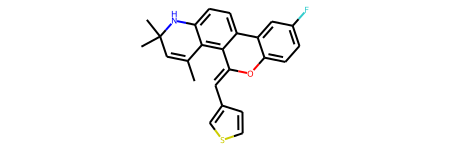

In [3]:
smiles = list(data['canonical_smiles'])
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]
molecules[0]

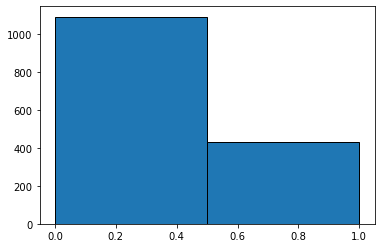

In [4]:
ACTIVITY_LVL = 5.4
labels = to_log_p(list(data['standard_value']))
labels = [1 if value < ACTIVITY_LVL else 0 for value in labels]

plt.hist(labels,2, edgecolor='black')
plt.show()

In [5]:
dataset = [mol_to_torch_data(mol) for mol in molecules]
dataset = [add_label(graph, label) for graph, label in zip(dataset, labels)]
dataset[0]

Data(x=[28, 6], edge_index=[2, 64], edge_attr=[64], y=[1, 1])

Graph with 28 nodes and 32 edges


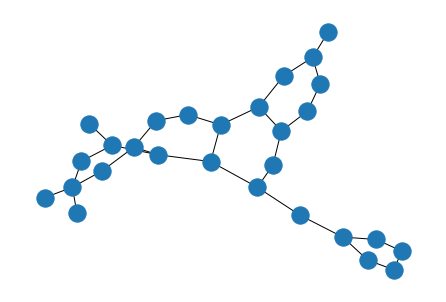

In [6]:
g = to_networkx(dataset[0], to_undirected=True)
nx.draw(g)
print(g)

In [48]:
batch_size = 256
train_dataset, test_dataset = train_test_split(dataset, 0.3) 

train_data_loader = DataLoader(train_dataset, batch_size)
test_data_loader = DataLoader(test_dataset, batch_size)

model = GCN_Graph(128, 512)

In [60]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

In [76]:
losses = []

for _ in tqdm(range(250)):
    loss = train_GCN(model, train_data_loader, optimizer, criterion)
    losses.append(loss)

100%|██████████| 250/250 [00:30<00:00,  8.28it/s]


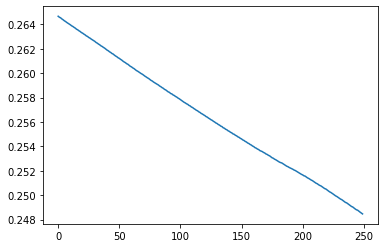

In [77]:
plt.plot(losses)
plt.show()

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88       364
         1.0       0.54      0.66      0.59        91

    accuracy                           0.82       455
   macro avg       0.73      0.76      0.74       455
weighted avg       0.84      0.82      0.83       455



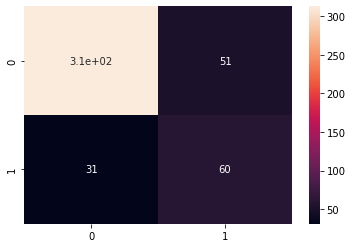

In [78]:
report, conf_mat = evaluate_GCN(model, test_data_loader)
print(report)

sns.heatmap(conf_mat, annot=True, )
plt.show()

In [79]:
labels = []
with torch.no_grad():
    
    for idx, batch in enumerate(train_data_loader):
        out = model.forward(batch.to("cuda"),return_embeds=True)
        out = out.cpu().numpy()
        labels+=[y.item() for y in batch.y]
        
        if idx == 0:
            outputs = out
        else:
            outputs = np.vstack((outputs, out))

labels = ["green" if var==1 else "red" for var in labels]


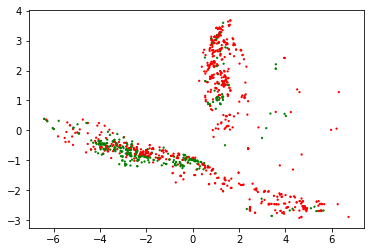

In [80]:
pca = PCA(2)
res = pca.fit_transform(outputs)

plt.scatter(res[:,0], res[:,1], c=labels, s=1.5)
plt.show()

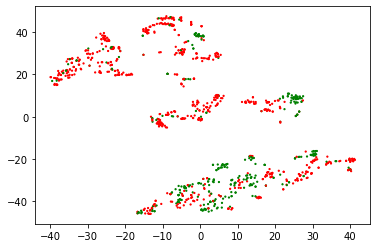

In [81]:
tsne = TSNE(2)
res = tsne.fit_transform(outputs)

plt.scatter(res[:,0], res[:,1], c=labels, s=1.5)
plt.show()